In [1]:
import sys
sys.path.append('../..') # Asegúrate de que Python pueda encontrar el paquete src

# importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt

from src.physics.pulses import GaussianPulse1D, format_value
from src.physics.crystals import KTPCrystal, KTPCrystal_Kato
from src.physics.nonlinear_optics import PhaseMatching
from src.physics.nonlinear_optics import second_harmonic_generation

In [2]:
# Parámetros iniciales
L = 0.0004  # Longitud de la cavidad en metros (0.4 mm)
gaussian_steps = 2000  # Número de pasos para la simulación del pulso gaussiano 

# Parámetros del pulso en longitud de onda
input_width_wl = 44e-9  # FWHM en metros (44 nm)
fundamental_wavelength = 795e-9  # Longitud de onda central en metros (795 nm)
fundamental_wavelength_um = fundamental_wavelength * 1e6  # en μm (0.795 μm)

# Inicializar pulso en longitud de onda
input_pulse = GaussianPulse1D(x0=fundamental_wavelength, FWHM=input_width_wl, steps=gaussian_steps, domain_width_std=5)
sigma_wavelength = input_pulse.standard_deviation()  # ~1.8728e-08 m
wavelength, A_lambda = input_pulse.generate_pulse(normalization=True)
wavelength, I_lambda = input_pulse.generate_intensity()

# Conversión a frecuencia angular (rad/s)
c = 299792458  # Velocidad de la luz en m/s
fundamental_frequency = 2 * np.pi * c / fundamental_wavelength  # Frecuencia angular central (rad/s)
sigma_frequency = (2 * np.pi * c) / (fundamental_wavelength ** 2) * sigma_wavelength  # Desviación en rad/s
FWHM_frequency = sigma_frequency * 2 * np.sqrt(2 * np.log(2))  # FWHM en rad/s

# Inicializar pulso en frecuencia
input_pulse_omega = GaussianPulse1D(x0=fundamental_frequency, FWHM=FWHM_frequency, steps=gaussian_steps, domain_width_std=5)
frequencies, A_omega = input_pulse_omega.generate_pulse(normalization=True)
frequencies, I_omega = input_pulse_omega.generate_intensity(normalization=True)

# Parámetros para SHG
SHG_frequencies = 2 * frequencies  # Frecuencias de la segunda armónica
SHG_wavelength = fundamental_wavelength / 2  # ~397.5 nm
SHG_wavelength_um = SHG_wavelength * 1e6  # ~0.3975 μm

# Imprimir parámetros
print("Parameters of the Gaussian pulse in wavelength domain:")
print("-" * 60)
pulse_dict = input_pulse.as_dict()
for key, value in pulse_dict.items():
    formatted_value = format_value(value)
    print(f"{key.replace('_', ' ').title()}: {formatted_value}")

print("\n")
print("Parameters of the Gaussian pulse in frequency domain:")
print("-" * 60)
pulse_dict_omega = input_pulse_omega.as_dict()
for key, value in pulse_dict_omega.items():
    formatted_value = format_value(value)
    print(f"{key.replace('_', ' ').title()}: {formatted_value}")

Parameters of the Gaussian pulse in wavelength domain:
------------------------------------------------------------
Center: 7.9500e-07
Fwhm: 4.4000e-08
Sigma: 1.8685e-08
Steps: 2000
Domain Width Std: 5
Computed Fwhm: 4.4000e-08


Parameters of the Gaussian pulse in frequency domain:
------------------------------------------------------------
Center: 2.3694e+15
Fwhm: 1.3114e+14
Sigma: 5.5688e+13
Steps: 2000
Domain Width Std: 5
Computed Fwhm: 1.3114e+14


In [3]:
frequencies

array([2.09093327e+15, 2.09121185e+15, 2.09149043e+15, ...,
       2.64725566e+15, 2.64753423e+15, 2.64781281e+15], shape=(2000,))

In [4]:
SHG_frequencies

array([4.18186654e+15, 4.18242369e+15, 4.18298085e+15, ...,
       5.29451131e+15, 5.29506847e+15, 5.29562563e+15], shape=(2000,))

In [5]:
SHG_amplitud_no_QPM, frequencies, pmf_no_QPM = second_harmonic_generation(pulse_y=A_omega, pulse_x=frequencies, SHG_frequencies=SHG_frequencies,
                                                              fundamental_wavelength_um=fundamental_wavelength_um, cavity_length=L, poling_period_um=None)

poling_period_um = 3.19  # Período QPM en micrómetros AFINAR VALOR DEL CRISTAL
SHG_amplitud_with_QPM, frequencies, pmf_with_QPM = second_harmonic_generation(pulse_y=A_omega, pulse_x=frequencies, SHG_frequencies=SHG_frequencies,
                                                                fundamental_wavelength_um=fundamental_wavelength_um, cavity_length=L, poling_period_um=poling_period_um)

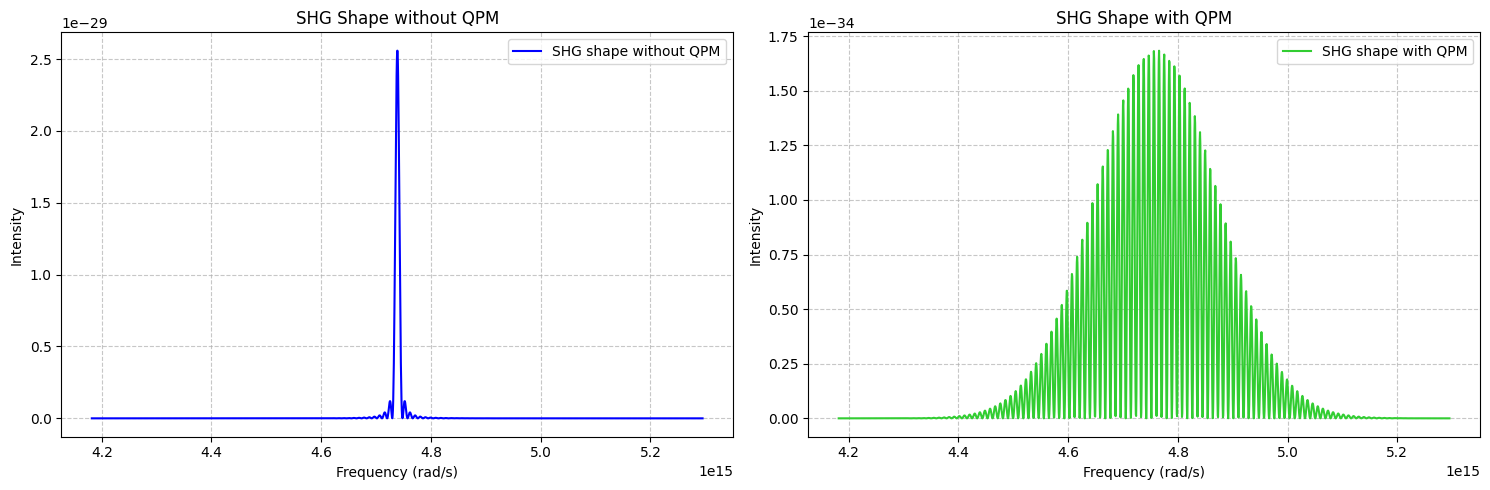

In [6]:
begin = 0
end = -1

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
SHG_frequencies_plot_interval = SHG_frequencies[begin: end]
SHG_shape_no_qpm_plot_interval = SHG_amplitud_no_QPM[begin: end]

plt.plot(SHG_frequencies_plot_interval, np.abs(SHG_shape_no_qpm_plot_interval)**2, label='SHG shape without QPM', color='blue')
plt.xlabel('Frequency (rad/s)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('SHG Shape without QPM')
plt.ylabel('Intensity')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend()

plt.subplot(1, 2, 2)

SHG_frequencies_plot_interval = SHG_frequencies[begin: end]
SHG_shape_with_qpm_plot_interval = SHG_amplitud_with_QPM[begin: end]

plt.plot(SHG_frequencies_plot_interval, np.abs(SHG_shape_with_qpm_plot_interval)**2, label='SHG shape with QPM', color='limegreen')
plt.xlabel('Frequency (rad/s)')
plt.title('SHG Shape with QPM')
plt.ylabel('Intensity')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend()

plt.tight_layout()
plt.show()

### Ajuste de parámetros de la gaussiana obtenida

In [7]:
from scipy.optimize import curve_fit
# Tener en cuenta que se tomaron en total 2000 puntos (variable 'gaussian_steps', tenerla en cuenta)
begin_ = 920
end_ = 1100

SHG_frequencies_plot_interval = SHG_frequencies[begin_: end_]
SHG_shape_no_qpm_plot_interval = SHG_amplitud_no_QPM[begin_: end_]

intensity = (np.abs(SHG_shape_no_qpm_plot_interval)**2) / (np.max(np.abs(SHG_shape_no_qpm_plot_interval)**2))  # intensidad normalizada.

# Definir la función gaussiana
def funcion_gaussiana(x, A, mu, sigma):
    return A * np.exp(-((x - mu)**2) / (2 * sigma**2))

parametros_iniciales = [2, 0.1, 1.2]  # Estimaciones iniciales
parametros_optimos, covarianza = curve_fit(funcion_gaussiana,
                                           xdata=SHG_frequencies_plot_interval*1e-15, ydata=intensity,
                                           p0=parametros_iniciales)

# Extraer los parámetros ajustados
amplitud_ajustada, media_ajustada, sigma_ajustada = parametros_optimos

# Generar la curva ajustada con los parámetros óptimos
y_ajustada = funcion_gaussiana(SHG_frequencies_plot_interval*1e-15, amplitud_ajustada, media_ajustada, sigma_ajustada)

In [8]:
# Constantes
c = 2.99792458e8  # Velocidad de la luz en m/s
mu = 4.738746e15  # Frecuencia angular en rad/s
f_0 = mu / (2 * np.pi)  # Frecuencia lineal en Hz
lambda_0 = c / f_0  # Longitud de onda central en m
lambda_0_nm = lambda_0 * 1e9  # Convertir a nm

delta_omega = 0.007907e15  # FWHM en rad/s
delta_f = delta_omega / (2 * np.pi)  # Convertir a Hz
delta_lambda_angular = (c / (f_0**2)) * delta_f
delta_lambda_angular_nm = delta_lambda_angular * 1e9


print(f"Longitud de onda central: {lambda_0_nm:.2f} nm")
print(f"FWHM en longitud de onda: {delta_lambda_angular_nm:.2f} nm")

Longitud de onda central: 397.50 nm
FWHM en longitud de onda: 0.66 nm


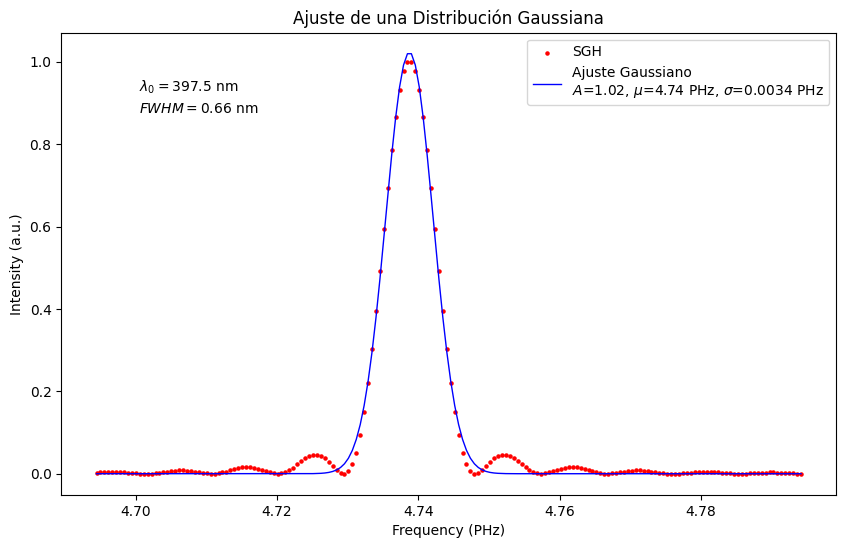

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(SHG_frequencies_plot_interval*1e-15, intensity, label='SGH', color='red', s=5)
plt.plot(SHG_frequencies_plot_interval*1e-15, y_ajustada, 
         label=f'Ajuste Gaussiano\n$A$={amplitud_ajustada:.2f}, $\\mu$={media_ajustada:.2f} PHz, $\\sigma$={sigma_ajustada:.4f} PHz', 
         color='blue', linewidth=1)

# Agregar dos textos en LaTeX para simular salto de línea
plt.text(0.1, 0.90, r'$\lambda_0 = {:.1f}$ nm'.format(lambda_0_nm), 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.1, 0.85, r'$FWHM = {:.2f}$ nm'.format(delta_lambda_angular_nm), 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

plt.title('Ajuste de una Distribución Gaussiana')
plt.xlabel('Frequency (PHz)')
plt.ylabel('Intensity (a.u.)')
plt.legend()
plt.show()

FWHM analítico: 0.007909 unidades de tiempo
FWHM numérico: 0.007910 unidades de tiempo


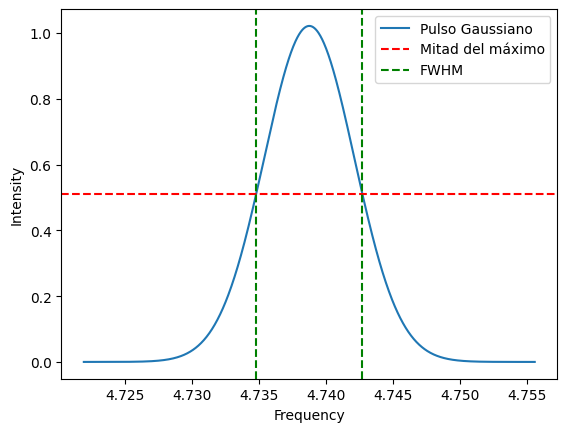

In [10]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Parámetros del ajuste
A = 1.021362  # Amplitud
mu = 4.738746  # Media | PHz
sigma = 0.00335885  # Desviación estándar | PHz (mu = 4.738746 PHz = 4.738746*e15 Hz)

# Cálculo analítico del FWHM
fwhm_analytic = sigma * 2 * np.sqrt(2 * np.log(2))
print(f"FWHM analítico: {fwhm_analytic:.6f} unidades de tiempo")

# Generar datos para verificación numérica
fre_ = np.linspace(mu - 5*sigma, mu + 5*sigma, 1000)  # Rango centrado en mu
intensity = A * np.exp(-((fre_ - mu)**2) / (2 * sigma**2))

# Función para calcular FWHM numéricamente (como en la respuesta anterior)
def calculate_fwhm(time, intensity):
    max_val = np.max(intensity)
    half_max = max_val / 2.0
    above_half = np.where(intensity >= half_max)[0]
    if len(above_half) == 0:
        raise ValueError("No se encontró región por encima de half-max.")
    
    left_idx = above_half[0]
    if intensity[left_idx] == half_max:
        left_time = time[left_idx]
    else:
        f_left = interp1d(intensity[left_idx-1:left_idx+1], time[left_idx-1:left_idx+1])
        left_time = f_left(half_max)
    
    right_idx = above_half[-1]
    if intensity[right_idx] == half_max:
        right_time = time[right_idx]
    else:
        f_right = interp1d(intensity[right_idx:right_idx+2], time[right_idx:right_idx+2])
        right_time = f_right(half_max)
    
    return right_time - left_time

# Calcular FWHM numérico
fwhm_numeric = calculate_fwhm(fre_, intensity)
print(f"FWHM numérico: {fwhm_numeric:.6f} unidades de tiempo")

# Visualización
plt.plot(fre_, intensity, label='Pulso Gaussiano')
plt.axhline(A/2, color='r', linestyle='--', label='Mitad del máximo')
plt.axvline(mu - fwhm_analytic/2, color='g', linestyle='--', label='FWHM')
plt.axvline(mu + fwhm_analytic/2, color='g', linestyle='--')
plt.xlabel('Frequency')
plt.ylabel('Intensity')
plt.legend()
plt.show()

### Pulso de entrada generado por SHG

In [11]:
# Inicializar pulso en frecuencia
p_2omega = GaussianPulse1D(x0=mu, FWHM=fwhm_numeric, steps=gaussian_steps, domain_width_std=30)
frequencies__, alpha_2omega  = p_2omega.generate_pulse(normalization=True)
frequencies__, intensity_2omega  = p_2omega.generate_intensity(normalization=True)

# Imprimir parámetros
print("Parameters of the Gaussian pulse in wavelength domain:")
print("-" * 60)
pulse_dict = p_2omega.as_dict()
for key, value in pulse_dict.items():
    formatted_value = format_value(value)
    print(f"{key.replace('_', ' ').title()}: {formatted_value}")
    
    

Parameters of the Gaussian pulse in wavelength domain:
------------------------------------------------------------
Center: 4.7387
Fwhm: 0.0079
Sigma: 0.0034
Steps: 2000
Domain Width Std: 30
Computed Fwhm: 0.0079


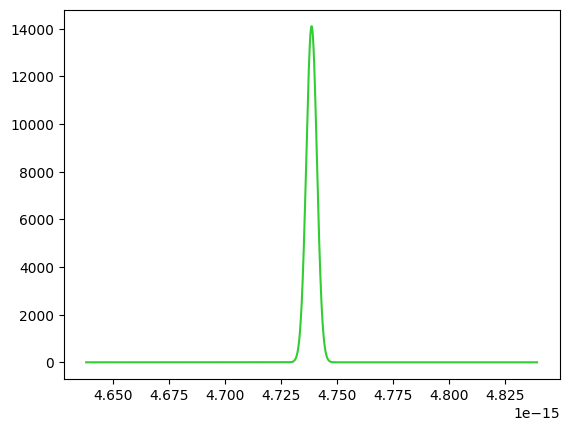

In [12]:
plt.plot(frequencies__ * 1e-15, np.abs(alpha_2omega)**2, label='SHG shape with QPM', color='limegreen')

### 3. Parametric Down Conversion (PDC) ###

Cálculo del JSA

El Joint Spectral Amplitude (JSA) se calcula como $JSA(\omega_s, \omega_i) = \alpha(\omega_s + \omega_i) \cdot \Phi(\omega_s, \omega_i)$, donde $\alpha$ es la envolvente del pulso de bombeo y $\Phi$ es la función de phase matching.

- $\alpha(\omega_p) = E_p(\omega_p)$, el campo del pulso de bombeo.
- $\Phi(\omega_s, \omega_i) = \text{sinc} \left( \frac{\Delta k L}{2} \right)$.

In [ ]:
# PDC parameters
crystal_length = 5e-3 #in m
lambda_0_SGH_um = 0.795  # (um) se usa la frecuencia fundamental que genera la frecuencia del segundo armónico, ya que , internamente la clase calcula la frecuencia del segundo armónico.

ktp = KTPCrystal()
pm_ = PhaseMatching(crystal=ktp, lambda_0_um=lambda_0_SGH_um)  # Calculate phase matching at fundamental wavelength

# IMPORTANT:  the frequencies must be the ones corresponding to the second harmonic
pmf_no_qpm = -pm_.phase_matching_function(SHG_frequencies, L=crystal_length, Lambda_um=None)  # Es el mismo phase matching que se usa en SHG, solo se cambia el signo para PDC.

# Calculo del JSA
JSA = alpha_2omega * pmf_no_qpm

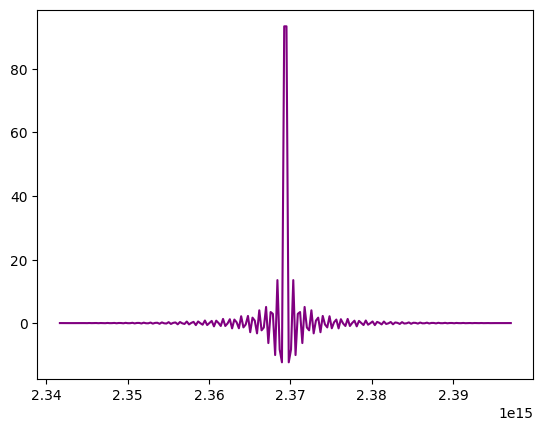

In [15]:
begin = 900
end = 1100

plt.plot(frequencies[begin: end], -JSA[begin: end], label='JSA', color='purple')
plt.show()

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


# Pulso SHG
omega_p = frequencies__  # Frecuencias SHG en PHz (rad/s) frequencies__, intensity_2omega
intensity_shg = intensity_2omega      # Intensidad 1D (|alpha_p|^2)

# Amplitud del pump: alpha_p = sqrt(intensity_shg)
alpha_p = np.sqrt(intensity_shg)  # Asumiendo fase cero

# Interpolador para alpha_p(omega_p)
interp_alpha_p = interp1d(omega_p, alpha_p, kind='linear', fill_value=0, bounds_error=False)

omega_range = omega_p / 2

# Crear malla 2D para omega_s y omega_i
omega_s, omega_i = np.meshgrid(omega_range, omega_range)

# Calcular omega_p = omega_s + omega_i
omega_p_mesh = omega_s + omega_i

# Evaluar alpha_p en la malla usando interpolación
alpha_p_mesh = interp_alpha_p(omega_p_mesh)

In [17]:
# Interpolador para pmf_no_QPM(omega_p)
interp_pmf_no_QPM = interp1d(omega_p, pmf_no_QPM, kind='linear', fill_value=0, bounds_error=False)

omega_range = omega_p / 2

# Crear malla 2D para omega_s y omega_i
omega_s, omega_i = np.meshgrid(omega_range, omega_range)

# Calcular omega_p = omega_s + omega_i
omega_p_mesh = omega_s + omega_i

# Evaluar alpha_p en la malla usando interpolación
pmf_no_QPM_mesh = interp_pmf_no_QPM(omega_p_mesh)

In [18]:
JSA = alpha_p_mesh * pmf_no_QPM_mesh
JSA_intensity = np.abs(JSA)**2

JSA_normalized = JSA / np.max(np.abs(JSA))

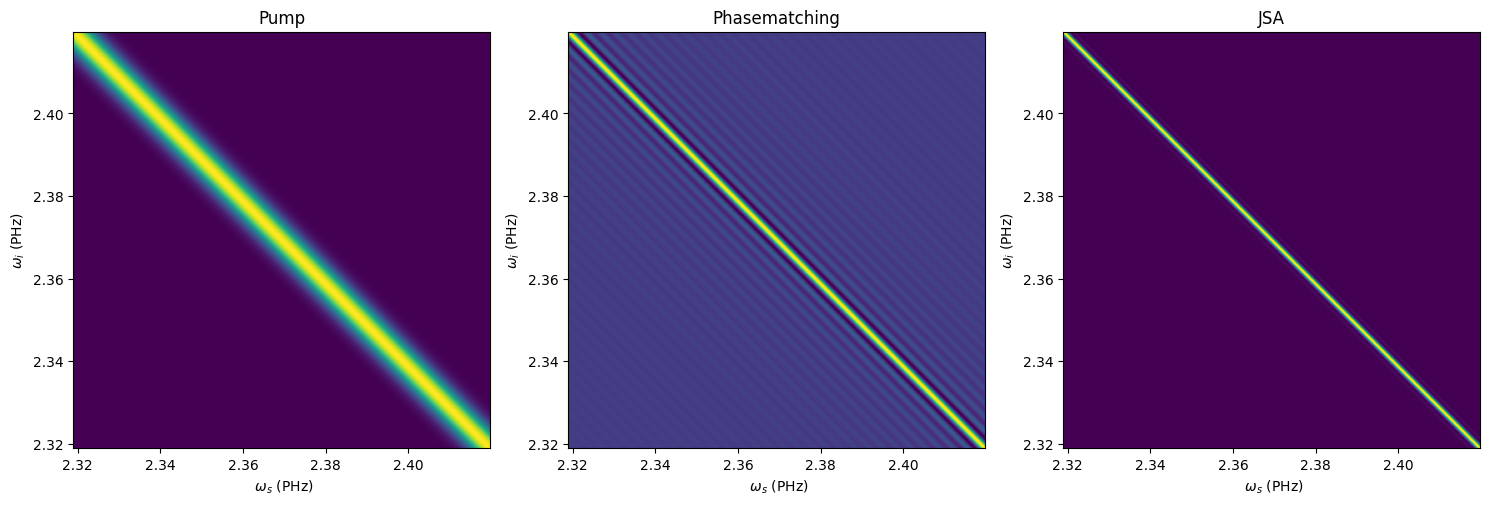

In [20]:
# --- Visualización Comparativa entrada y salida---
fig1, axs = plt.subplots(1,3,figsize=(15,5))

axs[0].pcolormesh(omega_range, omega_range, alpha_p_mesh, cmap='viridis', shading='auto')
axs[0].set_xlabel(r' $\omega_s$ (PHz)')
axs[0].set_ylabel(r'$\omega_i$ (PHz)')
axs[0].set_title('Pump')
axs[0].set_aspect('equal')

axs[1].pcolormesh(omega_range, omega_range, pmf_no_QPM_mesh, cmap='viridis', shading='auto')
axs[1].set_xlabel(r' $\omega_s$ (PHz)')
axs[1].set_ylabel(r'$\omega_i$ (PHz)')
axs[1].set_title('Phasematching')
axs[1].set_aspect('equal')

axs[2].pcolormesh(omega_range, omega_range, JSA_intensity , cmap='viridis', shading='auto')
axs[2].set_xlabel(r' $\omega_s$ (PHz)')
axs[2].set_ylabel(r'$\omega_i$ (PHz)')
axs[2].set_title('JSA')
axs[2].set_aspect('equal')

plt.tight_layout()
plt.show()